## Differential Evolution functions




In [1]:
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

# Constants
DIMENSIONS = 2
BOUND_LOW, BOUND_UP = -2, 2



durations = {}
# Function to generate a random neural network with given layer configurations
def generate_random_network(input_shape, num_categories):
    input_shape = (x_train.shape[1],)

    # Define the model
    model = Sequential([
            Dense(128, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(num_categories, activation='softmax')
        ])
    return model

def initialize_population(POPULATION_SIZE, input_shape, num_categories):
    """
    Function to initialize the population of individuals (neural network weights).
    """
    population = []

    # Generate random weights for each individual in the population
    for _ in range(POPULATION_SIZE):
        # Generate a random neural network
        model = generate_random_network(input_shape, num_categories)

        # Get the weights of each layer
        individual_weights = model.get_weights()
        population.append(individual_weights)

        # Randomly initialize the weights
        for inv in population:
            for arr in range(len(inv)):
                if arr % 2 == 1:
                    for i in range(len(inv[arr])):
                        inv[arr][i] = random.uniform(-2, 2)  # Use np.random.uniform for continuous values

    return population

def mutate(i, population, F, model, x_train, y_train_one_hot):
    """
    Function to mutate an individual in the population.
    """
    mutated_matrix = []
    vectors_indexes = []
    vectors_indexes.append(i)
    # print(i)

    for _ in range(3):
        while len(vectors_indexes) < 4:
            random_index = random.randint(0, len(population) - 1)
            while random_index not in vectors_indexes:
                vectors_indexes.append(random_index)

    Target_matrix = population[vectors_indexes[0]]

    for j in range(len(Target_matrix)):
        mutation_value = population[vectors_indexes[3]][j] + F * (population[vectors_indexes[1]][j] - population[vectors_indexes[2]][j])
        mutated_matrix.append(mutation_value)
    clip_matrix = [np.clip(item, BOUND_LOW, BOUND_UP) if isinstance(item, np.ndarray) else np.clip(item, BOUND_LOW, BOUND_UP) for item in mutated_matrix]

    return clip_matrix

def crossover(mutated_matrix, Target_matrix, C, model, x_train, y_train_one_hot):
    """
    Function to perform crossover between mutated and trail matrices.
    """
    trail_matrix = mutated_matrix

    for arr in range(len(Target_matrix)):
        for elm in range(len(Target_matrix[arr])):
            random_num = np.random.rand()  # Generate a single random number
            if random_num < C:
                trail_matrix[arr][elm] = mutated_matrix[arr][elm]
            else:
                trail_matrix[arr][elm] = Target_matrix[arr][elm]

    return trail_matrix

def select_best(target_matrix, trail_matrix, model, x_train, y_train_one_hot):
    """
    Function to select the best between the target and trail matrices.
    """
    model.set_weights(target_matrix)
    target_predictions = model.predict(x_train, verbose=0)
    loss_target = tf.keras.losses.categorical_crossentropy(y_train_one_hot, target_predictions).numpy()
    target_predicted_labels = np.argmax(target_predictions, axis=1)

    model.set_weights(trail_matrix)
    trail_predictions = model.predict(x_train, verbose=0)
    loss_trail = tf.keras.losses.categorical_crossentropy(y_train_one_hot, trail_predictions).numpy()
    trail_predicted_labels = np.argmax(trail_predictions, axis=1)

    accuracy_target = accuracy_score(y_train, target_predicted_labels)
    accuracy_trail = accuracy_score(y_train, trail_predicted_labels)

    return target_matrix if np.mean(loss_target) < np.mean(loss_trail) else trail_matrix

def calculate_loss(individual, x_train, y_train_one_hot):
    """
    Function to calculate loss and accuracy for an individual.
    """
    # Set weights to the model
    model.set_weights(individual)

    # Predict using the model
    predictions = model.predict(x_train, verbose=0)

    # Calculate loss
    loss = tf.keras.losses.categorical_crossentropy(y_train_one_hot, predictions).numpy()
    predicted_labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(y_train, predicted_labels)

    return np.mean(loss), accuracy

def evolve_population(ps, num_generation, input_shape, num_categories, F, C, x_train, y_train_one_hot):
    """
    Function to evolve the population over a number of generations.
    """
    # Initialize the population
    population = initialize_population(ps, input_shape, num_categories)

    # Initialize the model
    model = generate_random_network(input_shape, num_categories)

    best_individual = None
    best_accuracy = 0

    history = {}
    durations = datetime.timedelta(0)

    for generation in range(1, num_generation + 1):
        start_time = datetime.datetime.now()

        print(f"\nGeneration no : {generation}")

        # Initialize new_population_parallel for each generation
        new_population_parallel = []

        # Your existing code for population mutation and other tasks
        # Inside the for loop for population mutation and other tasks
        for i in range(0, len(population)):
            mutated_matrix = mutate(i, population, F, model, x_train, y_train_one_hot)
            trail_matrix = crossover(mutated_matrix, population[i], C, model, x_train, y_train_one_hot)
            best_matrix = select_best(population[i], trail_matrix, model, x_train, y_train_one_hot)
            new_population_parallel.append(best_matrix)


        # Calculate loss and accuracy for each individual in the new population
        losses_and_accuracy = np.array([calculate_loss(individual, x_train, y_train_one_hot) for individual in new_population_parallel])
        # Unpack the tuple correctly
        losses = [loss for loss, _ in losses_and_accuracy]


        # Find the individual with the lowest loss
        if losses:
            lowest_loss = np.min(losses)
            accuracy = losses_and_accuracy[(losses_and_accuracy == np.min(losses)).any(axis=1)][0][1]
            idx = np.where((losses_and_accuracy == np.min(losses_and_accuracy[:, 0])))
            print(f"Lowest loss in generation {generation}: {lowest_loss} and Accuracy : {accuracy}")

        population = new_population_parallel
        history[generation] = [int(idx[0][0]),lowest_loss , accuracy]
        pop_loss = []
        pop_accuracy = []
        best_ind = new_population_parallel[int(idx[0][0])]

        end_time = datetime.datetime.now()

        duration = end_time - start_time
        print(f"Time : {duration}")
        durations +=  duration

        # Terminate the algorithm if the best loss is less than 0.15 and accuracy is greater than 0.9
        if lowest_loss < 0.15 and accuracy > 0.9:
            print("Terminating algorithm because best loss is less than 0.15 and accuracy is greater than 0.9")
            break

    print(f"Total generations run Time : {durations}")
    return history, durations, best_ind, population



# Breast Cancer Dataset

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
#!pip install deap
import numpy as np
import random
#from deap import base
#from deap import creator
#from deap import tools
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Get the features and labels

# breast_cancer dataset
data = load_breast_cancer()
x = data.data
y = data.target
num_categories = len(np.unique(y))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

input_shape = (x_train.shape[1],)

# Define the model
model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_categories, activation='softmax')
    ])

# Feedforwarding the weights
predictions = model.predict(x_train, verbose = 0)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the loss using categorical crossentropy
loss = tf.keras.losses.categorical_crossentropy(y_train_one_hot, predictions).numpy()

print("Loss:", np.mean(loss))

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted_labels)
print("Accuracy:", accuracy)

# Get the weights of each layer
target_matrix = model.get_weights()
#print(target_matrix)


Loss: 0.6760065
Accuracy: 0.5428571428571428



Generation no : 1
Lowest loss in generation 1: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:21.503859

Generation no : 2
Lowest loss in generation 2: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:18.238917

Generation no : 3
Lowest loss in generation 3: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:17.151658

Generation no : 4
Lowest loss in generation 4: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:17.522536

Generation no : 5
Lowest loss in generation 5: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:19.256764

Generation no : 6
Lowest loss in generation 6: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:19.594702

Generation no : 7
Lowest loss in generation 7: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:17.438431

Generation no : 8
Lowest loss in generation 8: 0.3143128454685211 and Accuracy : 0.8703296703296703
Time : 0:00:16.613709

Generation no :

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Lowest loss in generation 120: 0.21507547795772552 and Accuracy : 0.945054945054945
Time : 0:00:21.107962
Total generations run Time : 0:37:05.004265


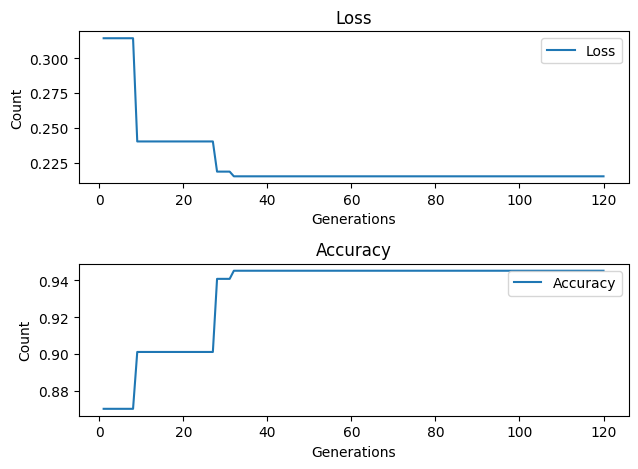

In [4]:
input_shape = (x_train.shape[1],)
num_categories = len(np.unique(y_train))
history_breast_cancer, runTime_breast_cancer, evolv_weights, best_population = evolve_population(50, 120, input_shape, num_categories, F=0.7, C=0.9, x_train=x_train, y_train_one_hot=y_train_one_hot)
model.set_weights(evolv_weights)
model.save('/content/G_breast_cancer.h5')
# Sample data
labels_breast_cancer = list(history_breast_cancer.keys())
losses_breast_cancer = [item[1] for item in history_breast_cancer.values()]
accuracies_breast_cancer = [item[2] for item in history_breast_cancer.values()]
durations['Breast Cancer'] = runTime_breast_cancer
# Create subplots
fig, axs = plt.subplots(2)

# Plot loss data
axs[0].plot(labels_breast_cancer, losses_breast_cancer, label='Loss')
axs[0].set_title('Loss')

# Plot accuracy data
axs[1].plot(labels_breast_cancer, accuracies_breast_cancer, label='Accuracy')
axs[1].set_title('Accuracy')

# Add common labels
for ax in axs:
    ax.set_xlabel("Generations")
    ax.set_ylabel("Count")
    ax.legend()
plt.savefig('evolutionary_algorithm_plots_iris.png')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



# Iris Daraset

In [5]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Get the features and labels

# breast_cancer dataset
data = load_iris()
x = data.data
y = data.target
num_categories = len(np.unique(y))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

input_shape = (x_train.shape[1],)

# Define the model
model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_categories, activation='softmax')
    ])

# Feedforwarding the weights
predictions = model.predict(x_train, verbose = 0)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the loss using categorical crossentropy
loss = tf.keras.losses.categorical_crossentropy(y_train_one_hot, predictions).numpy()

print("Loss:", np.mean(loss))

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted_labels)
print("Accuracy:", accuracy)

# Get the weights of each layer
target_matrix = model.get_weights()
#print(target_matrix)


Loss: 1.172775
Accuracy: 0.15833333333333333



Generation no : 1
Lowest loss in generation 1: 1.0150336027145386 and Accuracy : 0.44166666666666665
Time : 0:00:13.174061

Generation no : 2
Lowest loss in generation 2: 1.0150336027145386 and Accuracy : 0.44166666666666665
Time : 0:00:13.033066

Generation no : 3
Lowest loss in generation 3: 1.0150336027145386 and Accuracy : 0.44166666666666665
Time : 0:00:13.539490

Generation no : 4
Lowest loss in generation 4: 0.7902233004570007 and Accuracy : 0.5833333333333334
Time : 0:00:13.182660

Generation no : 5
Lowest loss in generation 5: 0.6474912166595459 and Accuracy : 0.5333333333333333
Time : 0:00:16.124651

Generation no : 6
Lowest loss in generation 6: 0.6474912166595459 and Accuracy : 0.5333333333333333
Time : 0:00:13.648120

Generation no : 7
Lowest loss in generation 7: 0.6474912166595459 and Accuracy : 0.5333333333333333
Time : 0:00:13.353869

Generation no : 8
Lowest loss in generation 8: 0.6474912166595459 and Accuracy : 0.5333333333333333
Time : 0:00:12.727280

Generation n

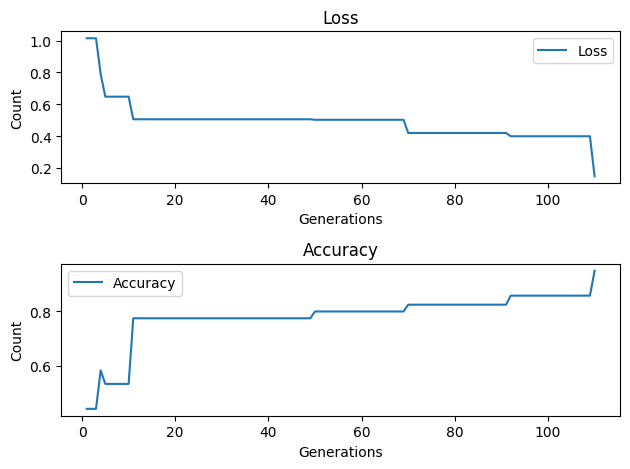

In [6]:
input_shape = (x_train.shape[1],)
num_categories = len(np.unique(y_train))
history_iris, runTime_iris, evolv_weights, best_population = evolve_population(50, 120, input_shape, num_categories, F=0.7, C=0.9, x_train=x_train, y_train_one_hot=y_train_one_hot)
model.set_weights(evolv_weights)

# Sample data
labels_iris = list(history_iris.keys())
losses_iris = [item[1] for item in history_iris.values()]
accuracies_iris = [item[2] for item in history_iris.values()]
durations['iris'] = runTime_iris
# Create subplots
fig, axs = plt.subplots(2)

# Plot loss data
axs[0].plot(labels_iris, losses_iris, label='Loss')
axs[0].set_title('Loss')

# Plot accuracy data
axs[1].plot(labels_iris, accuracies_iris, label='Accuracy')
axs[1].set_title('Accuracy')

# Add common labels
for ax in axs:
    ax.set_xlabel("Generations")
    ax.set_ylabel("Count")
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



# Wine Dataset


In [7]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Get the features and labels

# breast_cancer dataset
data = load_wine()
x = data.data
y = data.target
num_categories = len(np.unique(y))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

input_shape = (x_train.shape[1],)

# Define the model
model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_categories, activation='softmax')
    ])

# Feedforwarding the weights
predictions = model.predict(x_train, verbose = 0)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the loss using categorical crossentropy
loss = tf.keras.losses.categorical_crossentropy(y_train_one_hot, predictions).numpy()

print("Loss:", np.mean(loss))

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted_labels)
print("Accuracy:", accuracy)

# Get the weights of each layer
target_matrix = model.get_weights()
#print(target_matrix)


Loss: 1.1743847
Accuracy: 0.31690140845070425



Generation no : 1
Lowest loss in generation 1: 1.0626267194747925 and Accuracy : 0.4225352112676056
Time : 0:00:12.068516

Generation no : 2
Lowest loss in generation 2: 1.0626267194747925 and Accuracy : 0.4225352112676056
Time : 0:00:11.967216

Generation no : 3
Lowest loss in generation 3: 1.0626267194747925 and Accuracy : 0.4225352112676056
Time : 0:00:14.179635

Generation no : 4
Lowest loss in generation 4: 0.9795374274253845 and Accuracy : 0.4859154929577465
Time : 0:00:13.992467

Generation no : 5
Lowest loss in generation 5: 0.9795374274253845 and Accuracy : 0.4859154929577465
Time : 0:00:12.925409

Generation no : 6
Lowest loss in generation 6: 0.9237179756164551 and Accuracy : 0.47183098591549294
Time : 0:00:13.169143

Generation no : 7
Lowest loss in generation 7: 0.9237179756164551 and Accuracy : 0.47183098591549294
Time : 0:00:12.200235

Generation no : 8
Lowest loss in generation 8: 0.9237179756164551 and Accuracy : 0.47183098591549294
Time : 0:00:12.149678

Generation n

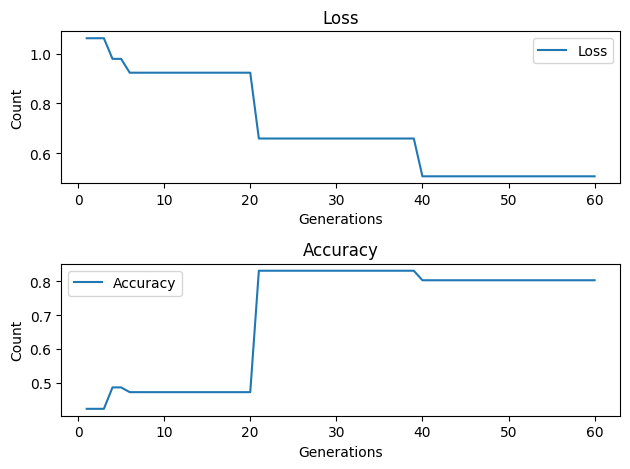

In [9]:
input_shape = (x_train.shape[1],)
num_categories = len(np.unique(y_train))
history_wine, runTime_wine, evolv_weights, best_population = evolve_population(50, 60, input_shape, num_categories, F=0.7, C=0.9, x_train=x_train, y_train_one_hot=y_train_one_hot)
model.set_weights(evolv_weights)

# Sample data
labels_wine = list(history_wine.keys())
losses_wine = [item[1] for item in history_wine.values()]
accuracies_wine = [item[2] for item in history_wine.values()]
durations['Wine'] = runTime_wine
# Create subplots
fig, axs = plt.subplots(2)

# Plot loss data
axs[0].plot(labels_wine, losses_wine, label='Loss')
axs[0].set_title('Loss')

# Plot accuracy data
axs[1].plot(labels_wine, accuracies_wine, label='Accuracy')
axs[1].set_title('Accuracy')

# Add common labels
for ax in axs:
    ax.set_xlabel("Generations")
    ax.set_ylabel("Count")
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



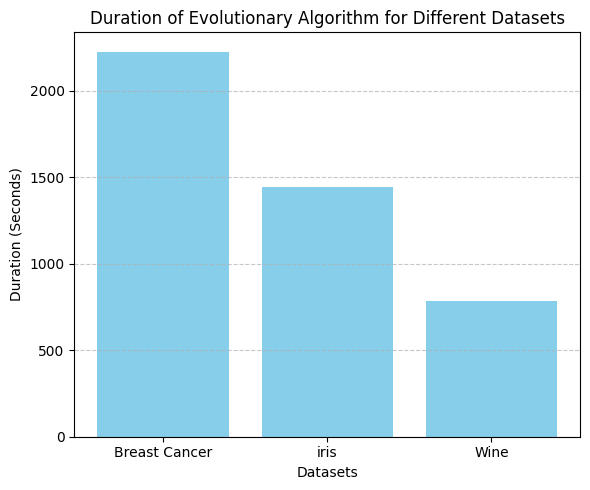

In [33]:
import matplotlib.pyplot as plt

# Dataset names and durations
datasets = ['Breast Cancer', 'iris', 'Wine']
durations_seconds = [durations[dataset].total_seconds() for dataset in datasets]

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(datasets, durations_seconds, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('Duration (Seconds)')
plt.title('Duration of Evolutionary Algorithm for Different Datasets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


In [30]:
print(f'{history_wine[np.max(list(history_wine.keys()))]}\n{history_iris[np.max(list(history_iris.keys()))]}\n{history_breast_cancer[np.max(list(history_breast_cancer.keys()))]}')

[46, 0.5061617493629456, 0.8028169014084507]
[7, 0.14651741087436676, 0.95]
[20, 0.21507547795772552, 0.945054945054945]


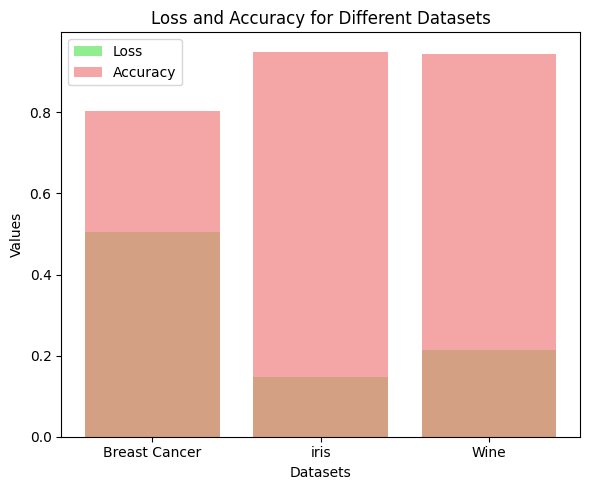

In [38]:
import matplotlib.pyplot as plt

# Data from history dictionaries
history_data = {
    'Wine': [46, 0.5061617493629456, 0.8028169014084507],
    'Iris': [7, 0.14651741087436676, 0.95],
    'Breast Cancer': [20, 0.21507547795772552, 0.945054945054945]
}


# Extracting values for plotting
losses = [data[1] for data in history_data.values()]
accuracies = [data[2] for data in history_data.values()]

# Plotting
plt.figure(figsize=(6, 5))

# Bar plot for losses and accuracies
plt.bar(datasets, losses, color='lightgreen', label='Loss')
plt.bar(datasets, accuracies, color='lightcoral', label='Accuracy', alpha=0.7)
plt.xlabel('Datasets')
plt.ylabel('Values')
plt.title('Loss and Accuracy for Different Datasets')
plt.legend()

plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import numpy as np
import random
import datetime
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class GeneticAlgorithm:
    def __init__(self, parameter_ranges, fitness_function, population_size=10, num_generations=50):
        self.parameter_ranges = parameter_ranges
        self.fitness_function = fitness_function
        self.population_size = population_size
        self.num_generations = num_generations

    def run(self):
        population = self._initialize_population()

        for generation in range(self.num_generations):
            fitness_values = [self.fitness_function(individual) for individual in population]
            selected_parents = self._selection(population, fitness_values)
            offspring = self._generate_offspring(selected_parents)
            population = offspring

        best_individual = max(population, key=lambda x: self.fitness_function(x))
        return best_individual

    def _initialize_population(self):
        population = []
        for _ in range(self.population_size):
            parameters = {param: np.random.uniform(*self.parameter_ranges[param]) for param in self.parameter_ranges}
            population.append(parameters)
        return population

    def _selection(self, population, fitness_values):
        # Implement selection operation
        # For simplicity, we'll use roulette wheel selection
        total_fitness = sum(fitness_values)
        probabilities = [fitness / total_fitness for fitness in fitness_values]
        selected_parents = random.choices(population, weights=probabilities, k=len(population))
        return selected_parents

    def _crossover(self, parent1, parent2):
        # Implement crossover operation
        # For simplicity, we'll use single-point crossover
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = {key: parent1[key] if i < crossover_point else parent2[key] for i, key in enumerate(parent1)}
        child2 = {key: parent2[key] if i < crossover_point else parent1[key] for i, key in enumerate(parent2)}
        return child1, child2

    def _mutation(self, individual):
        # Implement mutation operation
        # For simplicity, we'll use uniform mutation
        mutated_individual = {}
        for param, value in individual.items():
            mutation_range = self.parameter_ranges[param]
            mutated_value = value + np.random.uniform(-0.1, 0.1) * (mutation_range[1] - mutation_range[0])
            mutated_individual[param] = np.clip(mutated_value, *mutation_range)
        return mutated_individual

    def _generate_offspring(self, selected_parents):
        offspring = []
        for i in range(0, len(selected_parents), 2):
            parent1, parent2 = selected_parents[i], selected_parents[i+1]
            child1, child2 = self._crossover(parent1, parent2)
            child1 = self._mutation(child1)
            child2 = self._mutation(child2)
            offspring.extend([child1, child2])
        return offspring

In [ ]:
# Define the parameter space and fitness function
parameter_ranges = {
    'POPULATION_SIZE': (10, 100),  # Range for population size
    'F': (0.1, 1.0),  # Range for F
    'C': (0.1, 1.0)   # Range for C
}

def fitness_function(parameters):
    # parameters is a dictionary containing 'POPULATION_SIZE', 'F', and 'C'
    POPULATION_SIZE = int(parameters['POPULATION_SIZE'])  # Convert to integer
    F = parameters['F']
    C = parameters['C']

    # Run the evolutionary algorithm with current parameters and evaluate performance
    history = evolve_population(POPULATION_SIZE, num_generation=200, input_shape=input_shape, num_categories=num_categories, F=F, C=C, x_train=x_train, y_train_one_hot=y_train_one_hot)

    # Extract final accuracy from the history
    final_accuracy = history[10][2]  # Assuming 10 generations

    # Return negative accuracy as we want to maximize it
    return -final_accuracy

start = datetime.datetime.now()
# Create an instance of GeneticAlgorithm
ga = GeneticAlgorithm(parameter_ranges, fitness_function)

# Run the genetic algorithm
best_parameters = ga.run()
end = datetime.datetime.now()
print("Best Parameters:", best_parameters)
print(f"Total time : {start - end}")